In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import seaborn as sns
import time
from datetime import datetime, timedelta
import yfinance as yf
from arch import arch_model
from scipy.stats import norm
from scipy.optimize import newton
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Project 1 : 
### Calculation of implied volatility of 20 assets

[*********************100%%**********************]  20 of 20 completed


<Figure size 1000x600 with 0 Axes>

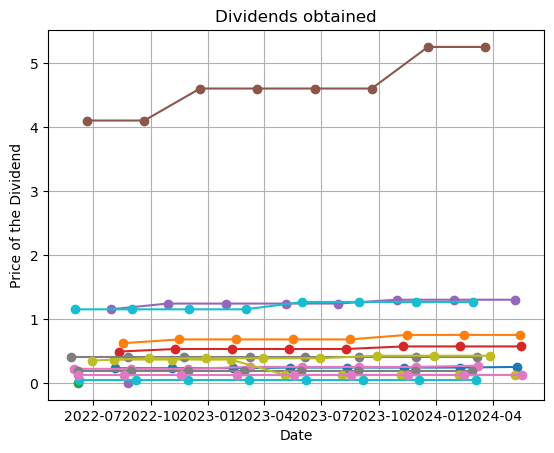

In [2]:
#-------------------

#All of tickers are companies from NASDAQ
symbols = ['AAPL','MSFT','AMZN','NFLX','TSLA','ABNB','EBAY','EA','INTC','NVDA','AMD','MRNA','PYPL','SBUX','TXN','AVGO','GEN','KHC','MDLZ','PEP']


end_date = datetime.now()
start_date = end_date - timedelta(days=365*2)

#We take an interval of time of 2years

#-------------------

sous_jacent = yf.download(symbols, start_date, end_date)["Close"]

#We build our analysis on the closing price of each day 
#-------------------

tickers = yf.Tickers(symbols)
dividend = []
start_date_str = start_date.strftime('%Y-%m-%d')
div_start_date = []

plt.figure(figsize=(10,6))

for i in range(len(symbols)):
    
    dividend.append(tickers.tickers[symbols[i]].actions)
    div_start_date.append(dividend[i].loc[start_date_str:])
    
    plt.figure("Dividend")
    plt.plot(div_start_date[i].index, div_start_date[i]["Dividends"], marker='o', linestyle='-')
    
plt.title("Dividends obtained")
plt.xlabel('Date')
plt.ylabel('Price of the Dividend')
plt.grid(True)
plt.show()

In [3]:
#-------------------


#Let's define the BS formula

def BS_prix_option(S=100, K=100, T=1, r=0.05, sigma=0.2, option_type='call'):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        prix_option = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        prix_option = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type is note valid. Choose: 'call' or 'put'.")

    return prix_option

#-------------------

#Let's define the implied volatility of an option with the Newton-Raphson's method

def vol_implicite(prix_option=10, S=100, K=100, T=1, r=0.05, option_type='call'):
    def f(sigma):
        return BS_prix_option(S, K, T, r, sigma, option_type) - prix_option

    vol_impli = newton(f, x0=0.2)

    return vol_impli

#The first function is more useful but she's an obstacle for the rest of the project ;)

def sigma(prix_option=10, S=100, K=100, T=1, r=0.05, option_type='call',n=500):
    a = 0
    b = 1000
    #We clumsily abuse the value of b
    #[a,b] correspond of the interval where sigma is
    for i in range(n):
        if prix_option > BS_prix_option(S=S, K=K, T=T, sigma=(a+b)/2, r=r , option_type=option_type):
            a = (a+b)/2
        else :
            b = (a+b)/2
    return (a+b)/2

#-------------------

#AN

vol_impli = vol_implicite()
print(f"Implied volatility : {vol_impli * 100}%.\nResult obtain with the Newton-Raphson's method\nand {sigma() *100}% with the function sigma")

#-------------------
 
#Let's calculate the implied volatility for each asset and for this we only gonna take calls
#Let's define the rate free

ratef = yf.download("^TNX")['Adj Close'][-1]

#-------------------
expirations = []
for symbol in symbols:
    expirations.append(yf.Ticker(symbol).options)

vol_implicite_call = []
vol_implicite_call_mean = []
opt_calls = []

for i in range(len(expirations)):
    tmp = []
    opt_call = []
    for j in range(len(expirations[i])):
        full_donnee =  yf.Ticker(symbols[i]).option_chain(expirations[i][j]).calls
        calls = full_donnee[['strike']].assign(calls=(full_donnee['lastPrice']))
        spot = sous_jacent[symbols[i]][-1]

        
        expiration = pd.to_datetime(expirations[i][j])
        jours_restants = float((expiration - datetime.today()).days)
        
        calls = calls.assign(Jours_restants = jours_restants)
        calls = calls[(calls['Jours_restants'] <= 50) & (calls['Jours_restants'] > 0)]
        calls = calls[(calls['strike']>=0.9*spot) & (calls['strike']<=1.1*spot)]
        opt_call.append(calls)
        for index, row in calls.iterrows():
            strike = row['strike']
            call = row['calls']
            matu = row['Jours_restants']
            if call == 0:
                pass
            else : 
                A = sigma(prix_option=call,S=spot,K=strike,T=round(matu/252,3),r=round(ratef/100,5),option_type='call')
                tmp.append(A)
    if tmp == []:
        vol_implicite_call.append(0)
        vol_implicite_call_mean.append(0)
    else:
        vol_implicite_call.append(tmp)
        vol_implicite_call_mean.append(np.nanmean(tmp))
    opt_calls.append(opt_call)


#-------------------

#Calcul of the historic volatility
#A trading year have 252 days

volatilite = []
tmp = 0

log_returns = np.log(sous_jacent / sous_jacent.shift(1))

for i in symbols:
    volatilite.append(np.sqrt(2*252) * log_returns[i].std())
    print(f"Volatilité historique du sous-jacent ({i}): {volatilite[tmp] * 100:.2f}%")
    tmp += 1
    
#-------------------

Implied volatility : 18.797164945691%.
Result obtain with the Newton-Raphson's method
and 18.797164945691016% with the function sigma


[*********************100%%**********************]  1 of 1 completed


Volatilité historique du sous-jacent (AAPL): 37.50%
Volatilité historique du sous-jacent (MSFT): 39.07%
Volatilité historique du sous-jacent (AMZN): 52.27%
Volatilité historique du sous-jacent (NFLX): 61.12%
Volatilité historique du sous-jacent (TSLA): 81.42%
Volatilité historique du sous-jacent (ABNB): 64.80%
Volatilité historique du sous-jacent (EBAY): 43.66%
Volatilité historique du sous-jacent (EA): 29.22%
Volatilité historique du sous-jacent (INTC): 55.87%
Volatilité historique du sous-jacent (NVDA): 73.39%
Volatilité historique du sous-jacent (AMD): 72.09%
Volatilité historique du sous-jacent (MRNA): 77.25%
Volatilité historique du sous-jacent (PYPL): 58.98%
Volatilité historique du sous-jacent (SBUX): 39.72%
Volatilité historique du sous-jacent (TXN): 37.58%
Volatilité historique du sous-jacent (AVGO): 48.48%
Volatilité historique du sous-jacent (GEN): 45.69%
Volatilité historique du sous-jacent (KHC): 28.89%
Volatilité historique du sous-jacent (MDLZ): 25.21%
Volatilité histori

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


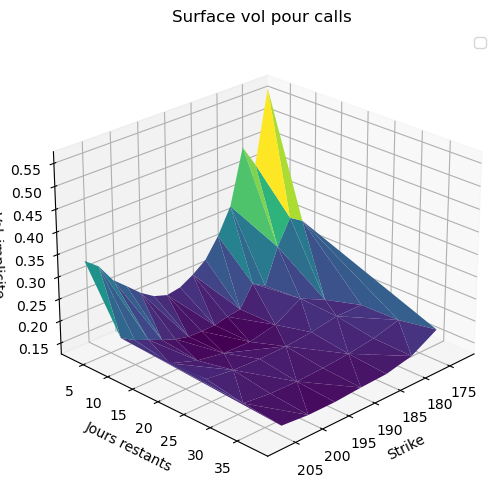

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


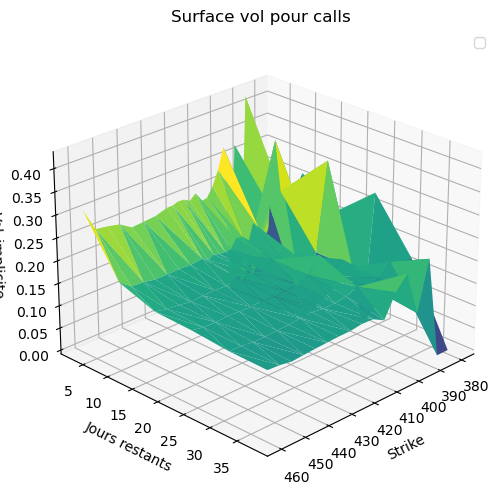

In [4]:
#-------------------

#Let's study the volatility surface of Apple and Microsoft's calls
for i in range(0,2):
    call = pd.concat(opt_calls[i],ignore_index=True)
    df_vol_implicite_call = pd.DataFrame(vol_implicite_call[i], columns=['Vol Implicite Call'])
    colonne = ['strike', 'Jours_restants']
    vol_surface = call[colonne].copy()
    vol_surface['Vol Implicite Call'] = vol_implicite_call[i]
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(vol_surface['strike'], vol_surface['Jours_restants'], vol_surface['Vol Implicite Call'], cmap='viridis')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Jours restants')
    ax.set_zlabel('Vol_implicite')
    ax.set_title('Surface vol pour calls')
    ax.legend()
    ax.view_init(elev=25., azim=45)
    plt.show()

#-------------------

# PROJECT 2 :
### Let's calculate the VaR and the Expected shortfall of our portfolio

he VaR_95% of our portfolio is -0.0209 and have been reach the 2022-06-28
This correspond to -2.09% of our capital
The VaR_95% at 10 days is 6.62%
The expected shortfall is 3.0% of our capital, that's represent 29.95€ for a portfolio of 1000€


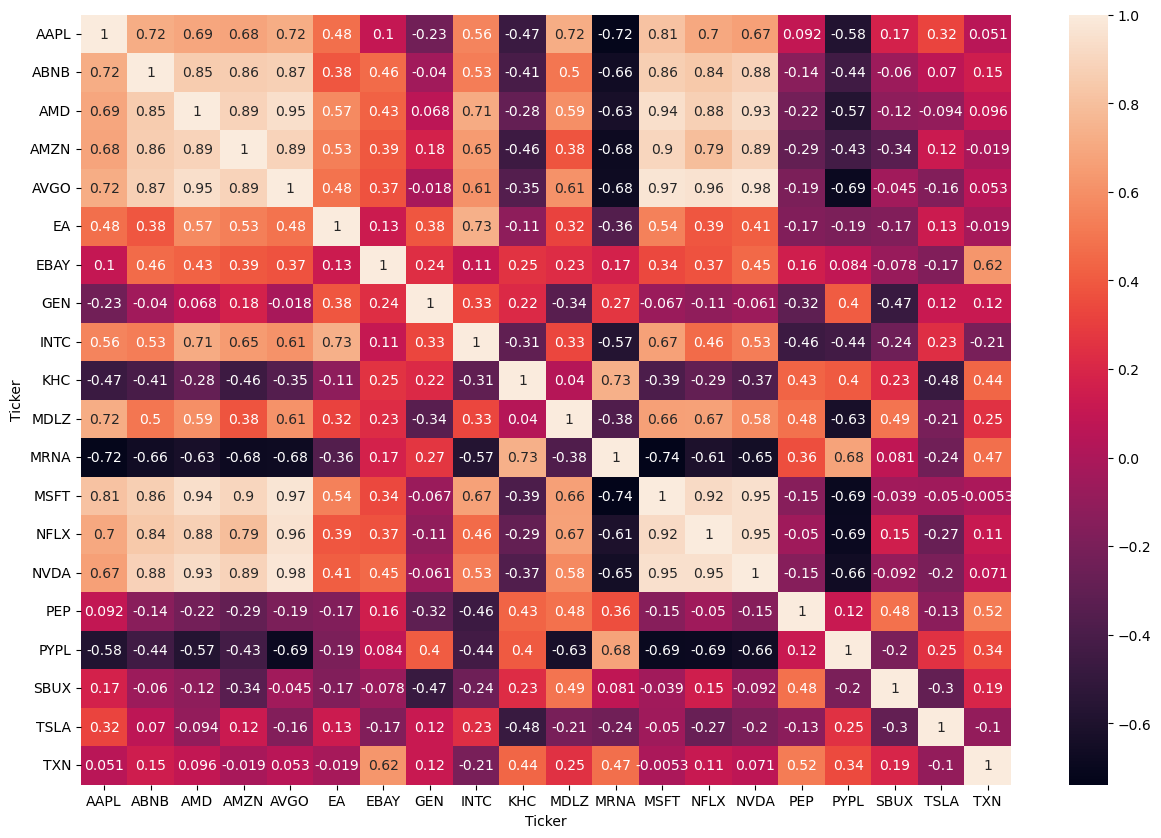

In [5]:
#-------------------

#Let's begin with the definition of the VaR and the Expected Shortfall

#VaR := loss which will not exceed with a probability (100-X)% for the next N days
#ES := Expected value of the conditional loss as a result of that she's be higher than VaR

#-------------------

#Yields calculations:

total_return = []
mean_return = []
a = 0

for i in symbols:
    tmp = []
    b = 0
    for j in range(len(sous_jacent[i])-1):
        if b < len(div_start_date[a].index) and sous_jacent[i].index[j].date() == div_start_date[a].index[b].date() :
            div = div_start_date[a]['Dividends'][b]
            b += 1
        else :
            div = 0
        tmp.append((sous_jacent[i][j+1]-sous_jacent[i][j]+div)/sous_jacent[i][j])
    total_return.append(tmp)
    mean_return.append(np.log(sous_jacent[i][-1]/sous_jacent[i][0]))
    a += 1
    
#-------------------

#Calculation of the portfolio : 



portfolio_asset_value = [np.sum(return_list) for return_list in total_return]
portfolio_asset_value_daily = np.array(total_return).T


portfolio_daily = np.sum(portfolio_asset_value_daily, axis=1) #For fair weight
portfolio = np.sum(portfolio_asset_value)


#print(round(np.sum(portfolio_daily),2) == round(portfolio,2))
#We can have some gap due to numerals after the comma

#-------------------

# Put the values into a dataframe

df_portfolio = pd.DataFrame(portfolio_asset_value_daily).T
nouvelle_colonne = [np.nan for _ in range(len(df_portfolio))]


df_portfolio[-1] = nouvelle_colonne
df_portfolio.index = df_portfolio.index + 1
df_portfolio = df_portfolio.T
df_portfolio = df_portfolio.sort_index() 

df_portfolio.index = sous_jacent.index
#-------------------

#Let's calculate the losses tie to each day :

poids_equi = 1/len(sous_jacent.columns)
perte = portfolio_daily * poids_equi
perte = np.insert(perte, 0, np.nan)
df_portfolio['Perte'] = perte #The loss right there refer to the yields' losses of every assets with the same weight 


# The VaR_95% correpondat the ceiling to whom we will not exceed in 95% of case during this duration
# If we have 500 days, the VaR will be realised during the 25th worth scenario

perte_sorted = sorted(perte)
scenario = math.ceil(0.05*len(sous_jacent))


print(f"he VaR_95% of our portfolio is {round(perte_sorted[scenario],4)} and have been reach the {df_portfolio.index[scenario-1].date()}")
print(f"This correspond to {round(perte_sorted[scenario]*100,2)}% of our capital")
print(f"The VaR_95% at 10 days is {round(abs(perte_sorted[scenario] * math.sqrt(10)) * 100,2)}%")
#-------------------

#Because we have 20 assets, we need to divide our capital. That's why in this section,
# we will proceed at a fair distribution. We must, with the 20 assets, have 5% of our capital in each asset.
#This will refer to poids_equi, let's calculate the ES (expected shortfall)

#-------------------

#Let M the revenu
M = 1000
ES = []
for i in perte_sorted[1:scenario]: #The first element of perte_sorted is not a number because we don't have any profitability in day 0
    ES.append(i)
ES = np.sum(ES)/len(ES)
print(f"The expected shortfall is {round(abs(ES * 100),2)}% of our capital, that's represent {round(abs(ES * M),2)}€ for a portfolio of {M}€")

#-------------------

#Let's calculate the correlation matrix

corr_sous_jacent = sous_jacent.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(corr_sous_jacent, annot=True)
plt.show()
#print(corr_sous_jacent['AAPL']['MSFT'])

#-------------------

### Let's apply the correlation between every assets

To calculate the correlation between every assets, we must look at the correlation matrix

Now let's calculate the covariance matrix with the follow formula :

$$ \sigma^{2}_{P} = \sum^{n}_{i=1} \sum^{n}_{j=1} cov_{ij} \alpha_{i} \alpha_{j}$$

Where $\alpha_{i}$ and $\alpha_{j}$ represent the amount of asset i and j 

$ i \in [1,n]$ and $ j \in [1,n]$


We can also calculate this matrix with the below formula:

$$ \sigma^{2}_{P} = \alpha^{T} C \alpha $$

Where $\alpha^{T}$ correspond to the transpose of the matrix $\alpha$ and C is the variance-covariance matrix

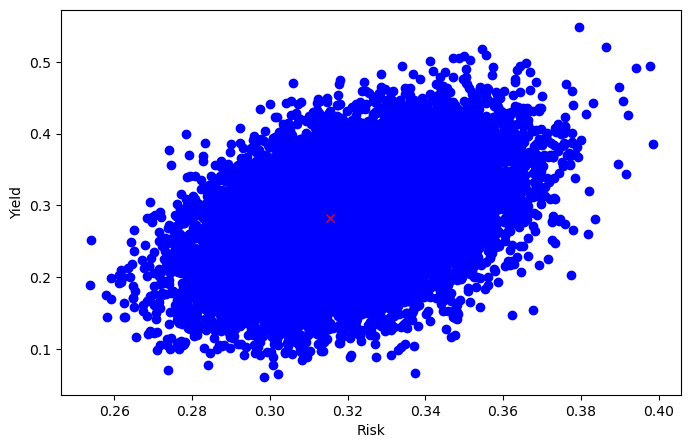

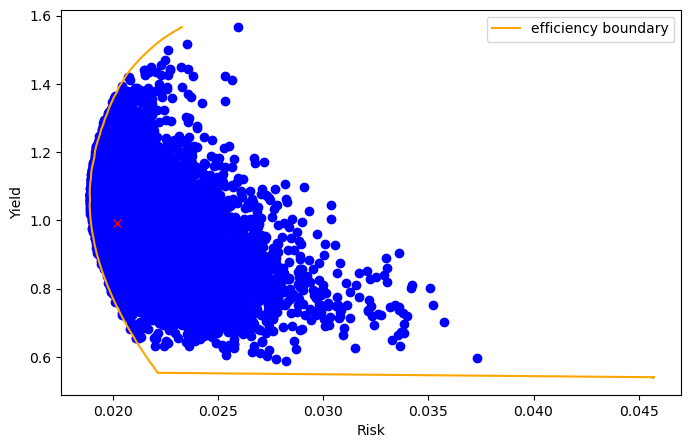

So the question is : Do Assets with less correlation have a better yield/risk ?
New assets use for our portfolio are : NVDA for reference asset (the most profitable) and ['GEN', 'AVGO', 'EBAY', 'NFLX']


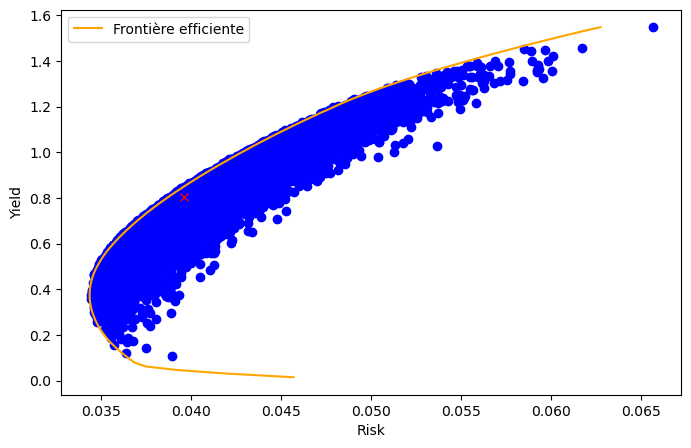

In [13]:
#-------------------

#Let's calculate the variance-covariance matrix:

Cov_Mat = np.cov(total_return)*len(sous_jacent)
#plt.figure(figsize=(15,10))
#sns.heatmap(Cov_Mat, annot=True, xticklabels=symbols, yticklabels=symbols)
#plt.show()

#-------------------

# alpha correspond of the associated amount for each asset. Like we have an fair portfolio, in every asset :

alpha = np.array([poids_equi for _ in symbols])
alpha_rendement = np.sum(np.multiply(alpha,mean_return))
sigma_p = math.sqrt(np.dot(np.dot(alpha.T,Cov_Mat),alpha))


#-------------------

def poids(n):
    x = np.random.rand(n)
    return x/sum(x)

def variance_pf(x,Cov):
    return np.dot(np.dot(np.transpose(x),Cov),x)

#-------------------

#Let's calculate the portfolio with random weights

n = 20000

plt.figure(figsize=(8,5))
for i in range(n):
    weight = poids(len(symbols))
    rendement = np.sum(np.multiply(weight,mean_return))
    var = math.sqrt(variance_pf(weight,Cov_Mat))
    plt.plot(var,rendement,'bo')
plt.plot(sigma_p,alpha_rendement,"rx")
plt.xlabel("Risk")
plt.ylabel('Yield')
plt.show()

#This code right there correspond to the efficiency barrier, but because we have a large portfolio, we need to rise n, but this will cost a large amount of time

#------------------- 

#Because a 20 assets' portfolio doesn't allow us to find the perfect efficiency barrier, for the rest of this section,
# we just gonna take 5 assets, for the first part, we gonna choose only assets with better yield
# And for the second part 5 assets which are not correlate. Maybe to be protect against risk

#-------------------

nbr_assets = 5

assets_trivial = []
mean_return_tmp = mean_return.copy()
for i in range(nbr_assets):
    tmp = sorted(mean_return_tmp, reverse=True)[i]
    condition = 0
    while tmp != mean_return[condition]:
        condition += 1
    assets_trivial.append(symbols[condition])  


#-------------------

#Let's show the variance-covariance matrix

poids_equi_assets = 1/nbr_assets

total_return_trivial = sorted(total_return, reverse=True)[0:nbr_assets]
mean_return_trivial = sorted(mean_return, reverse=True)[0:nbr_assets]
Cov_Mat_trivial = np.cov(total_return_trivial)*len(assets_trivial)

alpha_trivial = np.array([poids_equi_assets for _ in assets_trivial])
alpha_trivial_rendement = np.sum(np.multiply(alpha_trivial,mean_return_trivial))
sigma_p_trivial = math.sqrt(np.dot(np.dot(alpha_trivial.T,Cov_Mat_trivial),alpha_trivial))

#-------------------
returns = []
plt.figure(figsize=(8,5))
for i in range(n):
    weight = poids(len(assets_trivial))
    rendement = np.sum(np.multiply(weight,mean_return_trivial))
    returns.append(rendement)
    var = math.sqrt(variance_pf(weight,Cov_Mat_trivial))
    plt.plot(var,rendement,'bo')
plt.plot(sigma_p_trivial,alpha_trivial_rendement,"rx")
plt.xlabel("Risk")
plt.ylabel('Yield')

#-------------------

possible_returns = np.linspace(0,max(returns),100) 
poids_min = []
for ret in possible_returns:
    vol = lambda w: np.sqrt(np.dot(w,np.dot(w,Cov_Mat_trivial)))
    constraints = LinearConstraint([np.ones(nbr_assets),mean_return_trivial],[1,ret],[1,ret])
    w0 = poids(nbr_assets)
    sol = minimize(vol, w0, method='SLSQP', constraints = constraints, bounds=Bounds(0,1))
    poids_min.append(sol.x) 
    
#-------------------

ef_returns = []
ef_risks = []
for i in range(len(possible_returns)):
    ef_returns.append(sum(np.array(poids_min[i])*np.array(mean_return_trivial)))
    ef_risks.append(math.sqrt(variance_pf(poids_min[i], Cov_Mat_trivial)))
plt.plot(ef_risks, ef_returns, color='orange',label='efficiency boundary')
plt.legend()
plt.show()

print("So the question is : Do Assets with less correlation have a better yield/risk ?")

#-------------------

#Now let's consider the most profitability asset and 4 assets in whom he's not highly correlate  

tmp = sorted(mean_return, reverse=True)[0]
condition = 0
while tmp != mean_return[condition]:
    condition += 1
rang = condition
assets = symbols[condition]

cor_rang = np.sort(corr_sous_jacent[assets])[:-1]


#-------------------

indices_selectionnes = [cor_rang[i * len(cor_rang)//(nbr_assets-1)] for i in range(nbr_assets-1)]
indices = []
symbols_indices = []
for i in range(len(indices_selectionnes)):
    condition = np.where(corr_sous_jacent[symbols[rang]] == indices_selectionnes[i])[0][0]
    indices.append(condition)
    symbols_indices.append(symbols[condition])

print(f"New assets use for our portfolio are : {assets} for reference asset (the most profitable) and {symbols_indices}")
#-------------------

total_return_cor = [total_return[rang]] + [total_return[i] for i in indices]
mean_return_cor = [mean_return[rang]] + [mean_return[i] for i in indices]
Cov_Mat_cor = np.cov(total_return_cor)*nbr_assets
                                                
alpha_cor = np.array([poids_equi_assets] + [poids_equi_assets for _ in indices])
alpha_cor_rendement = np.sum(np.multiply(alpha_cor,mean_return_cor))
sigma_p_cor = math.sqrt(np.dot(np.dot(alpha_cor.T,Cov_Mat_cor),alpha_cor))

#-------------------

returns_cor = []
plt.figure(figsize=(8,5))
for i in range(n):
    weight = poids(len(indices)+1)
    rendement = np.sum(np.multiply(weight,mean_return_cor))
    returns_cor.append(rendement)
    var = math.sqrt(variance_pf(weight,Cov_Mat_cor))
    plt.plot(var,rendement,'bo')
plt.plot(sigma_p_cor,alpha_cor_rendement,"rx")
plt.xlabel("Risk")
plt.ylabel('Yield')

#-------------------

possible_returns_cor = np.linspace(0,max(returns_cor),100) 
poids_min_cor = []
for ret in possible_returns_cor:
    vol = lambda w: np.sqrt(np.dot(w,np.dot(w,Cov_Mat_cor)))
    constraints = LinearConstraint([np.ones(nbr_assets),mean_return_cor],[1,ret],[1,ret])
    w0 = poids(nbr_assets)
    sol = minimize(vol, w0, method='SLSQP', constraints = constraints, bounds=Bounds(0,1))
    poids_min_cor.append(sol.x) 
    
#-------------------

ef_returns_cor = []
ef_risks_cor = []
for i in range(len(possible_returns_cor)):
    ef_returns_cor.append(sum(np.array(poids_min_cor[i])*np.array(mean_return_cor)))
    ef_risks_cor.append(math.sqrt(variance_pf(poids_min_cor[i], Cov_Mat_cor)))
plt.plot(ef_risks_cor, ef_returns_cor, color='orange',label='efficiency boundary')
plt.legend()
plt.show()

#-------------------

In [15]:
#-------------------

#Let's retake the calcul of the VaR and the ES but with the portfolio which maximise the profit

max_portfolio = ef_returns[-1]
risk_portfolio = ef_risks[-1]
poids_portfolio = poids_min[-1]
print("This mean that we assign a weight of:")
for i in range(len(poids_portfolio)):
    print(f"{round(poids_portfolio[i]*100,2)}% to {assets_trivial[i]}")


#-------------------


#Same calcul with non correlated assets

max_portfolio_cor = ef_returns_cor[-1]
risk_portfolio_cor = ef_risks_cor[-1]
poids_portfolio_cor = poids_min_cor[-1]
print("\nThis mean that we assign a weight of:")
print(f"{round(poids_portfolio_cor[0]*100,2)}% to {assets}")
for i in range(1,len(poids_portfolio_cor)):
    print(f"{round(poids_portfolio_cor[i]*100,2)}% to {symbols_indices[i-1]}")
#-------------------

This mean that we assign a weight of:
73.34% to NVDA
26.66% to NFLX
0.0% to AVGO
0.0% to AMD
0.0% to AMZN

This mean that we assign a weight of:
69.66% to NVDA
0.0% to GEN
0.0% to AVGO
0.0% to EBAY
30.34% to NFLX


# PROJECT 3 :
### Binomial tree and Monte-Carlo

#### Price estimation of an option without dependence at her trajectory while using the Monte-Carlo's method

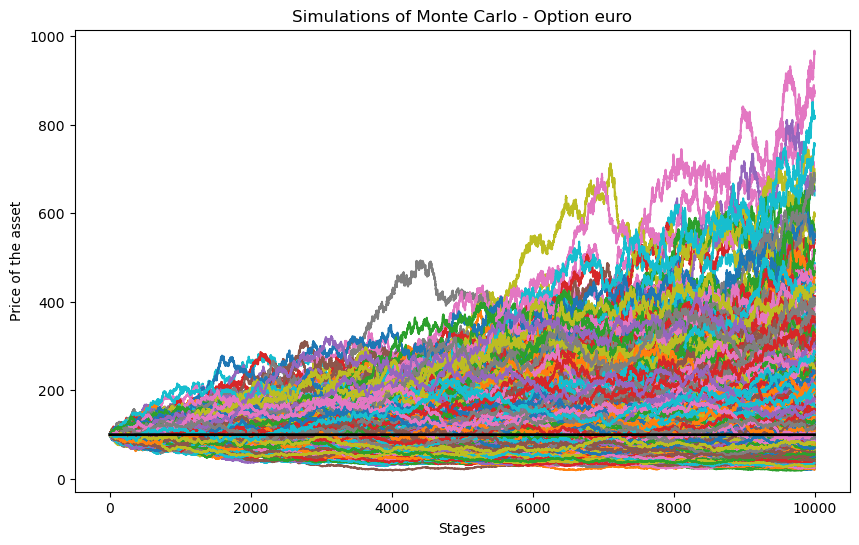

'The option value with the default settings is :61.95€'

In [95]:
#-------------------

def monte_carlo_continue(S0=100, K=100, N=1000, sigma=0.2, r=0.05, T=1, order = 'C', n=10000):
    """
    Return a simulation of the value of an option while using Monte-Carlo
    ---------
    
    Parameters : 
    
    - S0 : present price of the asset 
    - K : strike 
    - N : number of knots in the tree
    - sigma : Volatility
    - r : rate free
    - T : maturity
    - order : C (call) or P (put)
    - n : numbers of stages 
    
    ---------
    
    Return :
    
    - prime : estimation of the price of the option by Monte-Carlo
    """
    plt.figure(figsize=(10,6))
    plt.title('Simulations of Monte Carlo - Option euro')
    plt.xlabel('Stages')
    plt.ylabel('Price of the asset')
    
    ligne = [S0] * n
    
    dt = T/N
    t = dt*np.arange(1,n+1)
    Wt = (np.sqrt(dt)*np.random.standard_normal((N,n))).cumsum(1)
    S = S0 * np.exp((r-sigma**2/2)*t + sigma*Wt)
    for i in S:
        plt.plot(i)
    plt.plot(ligne, c='k',linewidth=2)
    S_T = np.mean([i[-1] for i in S])
    if order =='C':
        H = max(S_T-K,0)
    elif order =='P':
        H = max(K-S_T,0)
    else :
        raise ValueError("Invalid, the order must be 'P' or 'C'")
    prime = np.exp(-r*T)*H
    
    plt.show()
    
    return prime

f"The option value with the default settings is :{round(monte_carlo_continue(),2)}€"
#-------------------

#### Price estimation of an option with dependence at her trajectory while using the Monte-Carlo's method

29.20392531029205


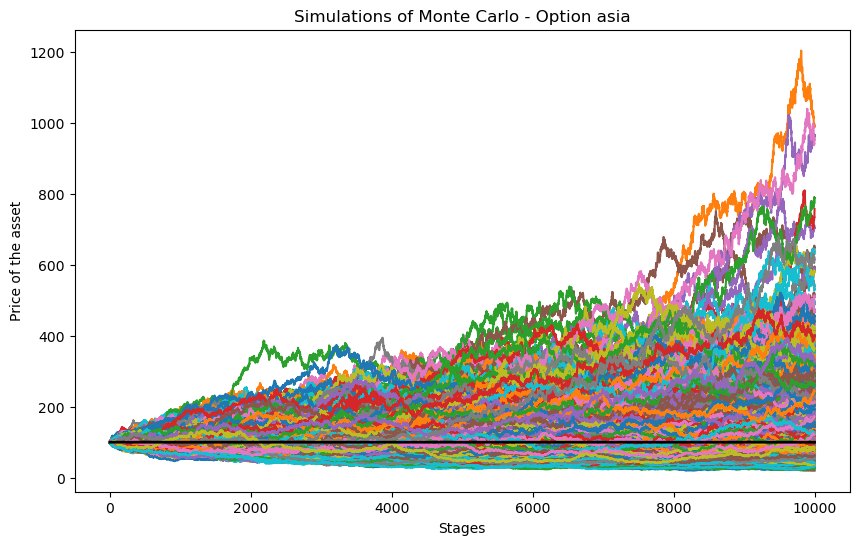

'The asia option value with the default settings is :27.78€'

In [27]:
#-------------------

def monte_carlo_continue_asia(S0=100, K=100, N=1000, sigma=0.2, r=0.05, T=1, order = 'C', n=10000):
    """
    Return a simulation of the value of an asia option while using Monte-Carlo
    ---------
    
    Parameters : 
    
    - S0 : present price of the asset 
    - K : strike 
    - N : number of knots in the tree
    - sigma : Volatility
    - r : rate free
    - T : maturity
    - order : C (call) or P (put)
    - n : numbers of stages 
    
    ---------
    
    Return :
    
    - prime : estimation of the price of the asia option by Monte-Carlo
    """
    plt.figure(figsize=(10,6))
    plt.title('Simulations of Monte Carlo - Option asia')
    plt.xlabel('Stages')
    plt.ylabel('Price of the asset')
    
    ligne = [S0] * n
    
    dt = T/N
    t = dt*np.arange(1,n+1)
    Wt = (np.sqrt(dt)*np.random.standard_normal((N,n))).cumsum(1)
    S = S0 * np.exp((r-sigma**2/2)*t + sigma*Wt)
    for i in S:
        plt.plot(i)
    
    plt.plot(ligne, c='k',linewidth=2)
    S_T = np.mean(np.mean(S,axis=1))
    if order =='C':
        H = max(S_T-K,0)
    elif order =='P':
        H = max(K-S_T,0)
    else :
        raise ValueError("Invalid, we must have order : 'P' or 'C'")
    prime = np.exp(-r*T)*H
    
    plt.show()
    
    return prime

#-------------------

f"The asia option value with the default settings is :{round(monte_carlo_continue_asia(),2)}€"
#-------------------

# PROJECT 4 :
### Brownian motion and convergence of the binomial model

#### The payoff for an europeen call européen have for expression : $$ h = \max(S_{T} - K,0) $$ with $S_{T}$ the asset price at the moment T and $K$ the strike
#### The payoff for an europeen put have for expression $$ h = \max(K - S_{T},0) $$
#### The prime for an europeen call is calculate with the follow equation $$ C_{n} = \frac{1}{(1+r)^{T-n}} \mathbb{E}_{\mathbb{P}_{*}}(h | \mathcal{F}_{n})$$ with $r$ the rate free, $h$ the payoff and $\mathcal{F}_{n}$ filtration at the moment $n$. This is the same formula for a put , i.e :  $$ P_{n} = \frac{1}{(1+r)^{T-n}} \mathbb{E}_{\mathbb{P}_{*}}(h | \mathcal{F}_{n})$$ except that $h$ is the payoff for an europeen put. This come down to rewrite the call like :  $$ C_{n} = \frac{1}{(1+r)^{T-n}} \mathbb{E}_{\mathbb{P}_{*}}( [S_{T} - K]_{+} | \mathcal{F}_{n})$$ and for the put, we will have so :  $$ P_{n} = \frac{1}{(1+r)^{T-n}} \mathbb{E}_{\mathbb{P}_{*}}( [K - S_{T}]_{+} | \mathcal{F}_{n})$$ 

##### All of those formula are true if we are taking $1+r$ as a compound rate, but if we would have taken a continuous rate, we would have wrote $1+r = \exp(rT)$

##### Let's remember that the neutral-risk probability is  : $$ \mathbb{P}_{*} =  [p_{*} * \delta(u) + (1-p_{*}) * \delta(d)]^{\otimes N} $$

In [107]:
def payoff(N=3, K=100, S0=100, T=1, r=0.05, sigma=0.2, order='C'):
    """
   Return the payoff of an europeen option 
    
    ---------
    
    Parameters :
    
    -N : number of period 
    -K : strike
    -S0 : price of the asset now
    -T : maturity
    -r : rate free for one year
    -sigma : volatility
    -order : C (Call) or P (Put)
    
    ---------
    
    Return :
    
    payoff 
    """
    rate = np.power(1+r,(T/N)) - 1
    dt = T/N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1/u
    S_T = []
    payoff = []        
    if d < math.exp(rate*T) and math.exp(rate*T) < u :
        proba = (math.exp(rate*T)-d)/(u-d)
    else :
        raise ValueError("Invalid, we must respect the condition : d < math.exp(rT) < u ")
    for i in range(0,N+1):
        S_T.append(S0 *(u**(N-i))*(d**i))
        if order == 'C':
            payoff.append(max(S_T[i]-K,0))
        elif order == 'P' : 
            payoff.append(max(K-S_T[i],0))
    return payoff

print(payoff())

[41.398245808051655, 12.240090244566758, 0, 0]


In [171]:
def prime(N=3, K=20, S0=20, T=1, r=0.05, sigma=0.2, order='C'):
    """
    Retourne the prime of an europeen option
    
    ---------
    
    Parameters :
    
    -N : number of period 
    -K : strike
    -S0 : price of the asset now
    -T : maturity
    -r : rate free for one year
    -sigma : volatility
    -order : C (Call) or P (Put)
    
    ---------
    
    Return :
    
    prime  
    """
    rate = np.power(1+r,(T/N)) - 1
    dt = T/N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1/u
    S_T = []
    h = payoff(N=N,K=K,S0=S0,T=T,r=r,sigma=sigma,order=order)

    prime = 0
    condition = 0        
    proba = (math.exp(rate*T)-d)/(u-d) #Condition check in the function "payoff"
    if order == 'P':
        h.reverse()
        # Put case
        while h[condition] > 0:
            prime += h[condition] * (1-proba)**(N-condition) * (proba)**condition * math.comb(N,condition)
            condition += 1
        prime *= math.exp(-rate*T)
        
    else :
        #Call case
        while h[condition] > 0:
            prime += h[condition] * proba**(N-condition) * (1-proba)**condition * math.comb(N,condition)
            condition += 1
        prime *= math.exp(-rate*T)
    return prime

print(prime(order='C'))

2.2739719693818947


In [172]:
def blackScholes(S0=20, K=20, T=1, r=0.05, sigma=0.2, ordre='C'):
    """
    Return the BS value
    
    ---------
    
    Parameters :
    
    -K : strike
    -S0 : price of the asset now
    -T : maturity
    -r : rate free
    -sigma : volatility
    -order : C (Call) or P (Put)
    
    ---------
    
    Return:
    
    prime of an europeen option with the BS model
    """
    d1 = (np.log(S0/K) + (r - sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if ordre == 'C':
            prix = S0*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif ordre == 'P':
            prix = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S0*norm.cdf(-d1, 0, 1)
        return prix
    except:
        raise ValueError("Order not valid, you must choose between 'C' and 'P' !")

In [173]:
print(round(blackScholes(),2))
print(round(prime(N=1000),2))

2.06
2.18


When we increase the number of periods, then we must have a convergence of the prime originate from the binomial tree toward the BS formula :$$C(S, t) = e^{-r\Delta t} \left[ p C(uS, t + \Delta t) + (1 - p) C(dS, t + \Delta t) \right]
 \xrightarrow{N \rightarrow \infty} C(S, t) = S_0 N(d_1) - K e^{-r(T-t)} N(d_2)
 $$  
 
 with $ d_1 = \frac{\ln(S_0 / X) + (r - \frac{\sigma^2}{2})(T - t)}{\sigma \sqrt{T - t}}$ and $ d_2 = d_1 - \sigma \sqrt{T - t} $
 
